About me

Angelique Twumasi
* E-mail: twumasiafia@gmail.com
*LinkedIn:  www.linkedin.com/in/angelique-twumasi-1b391a189
*Github: https://github.com/afiatwum


# **Unleashing Energy Insights: Harnessing SVR and XGBoost for Dynamic Forecasting**

 By leveraging machine learning models like Support Vector Regressor (SVR) and XGBoost, the project enables energy companies to generate highly accurate forecasts of energy consumption. This allows companies to better anticipate demand fluctuations and optimize their resource allocation accordingly.

In [1]:
#Importing all needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
color_pal= sns.color_palette()

In [2]:
#Reading csv file
df=pd.read_csv('PJME_hourly.csv')
df=df.set_index('Datetime')
df.index=pd.to_datetime(df.index)


In [3]:
#finding null values
df.isnull().sum()


PJME_MW    0
dtype: int64

In [4]:
#replaces the missing values with interpolated values
df['PJME_MW'].interpolate(method='linear', inplace=True)

<Axes: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

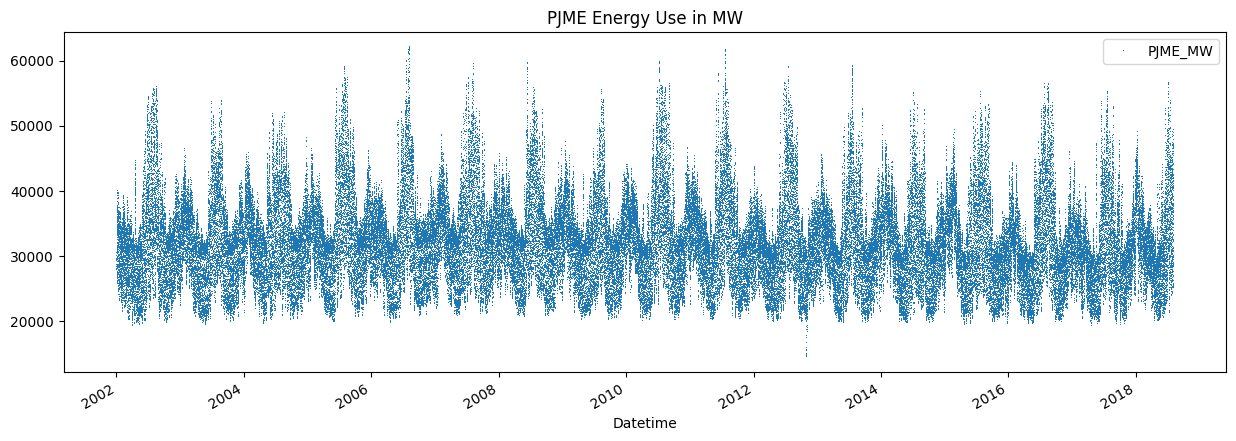

In [5]:
df.plot(style=',',
        figsize=(15,5),
        color=color_pal[0],
        title='PJME Energy Use in MW')


*The existing visualization reveals a prominent yearly seasonal pattern in the data, yet the unique attributes of each year remain obscured due to the graph's high density.*

# **Train/Test Split**

Training set:  01-01-2002-01-01-2015

Test Set: > =01-01-2015

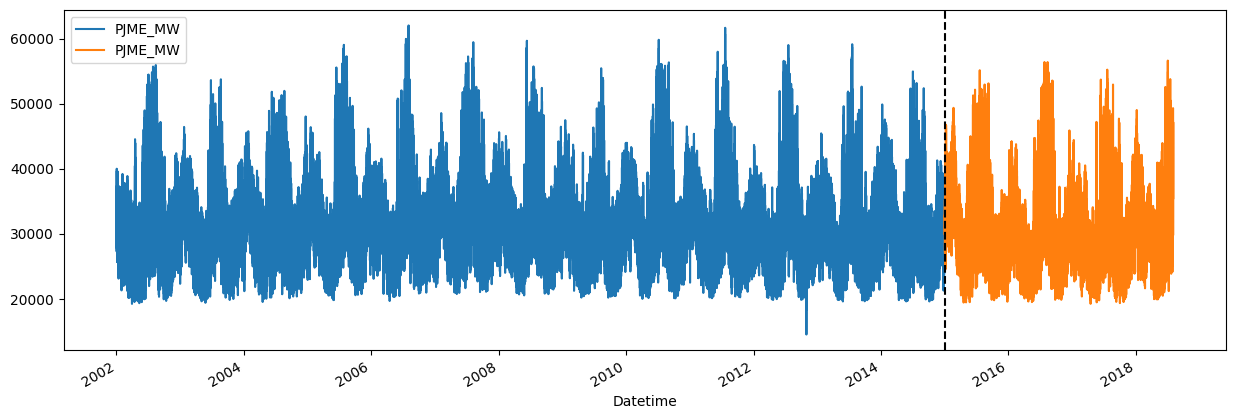

In [6]:
train= df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']
fig, ax= plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training set')
test.plot(ax=ax, label= 'Test set')
ax.axvline('01-01-2015', color= 'black', ls='--')

# **Feature Creation**

In [7]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)


# **Visualize our Feature/ Target Relationship**

<ipython-input-8-53af8b46404d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues' )
<ipython-input-8-53af8b46404d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='dayofweek', y='PJME_MW', palette='Reds')
<ipython-input-8-53af8b46404d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='dayofyear', y='PJME_MW', palette='Blues')
<ipython-input-8-53af8b46404d>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign t

Text(0.5, 1.0, 'MW by Hour')

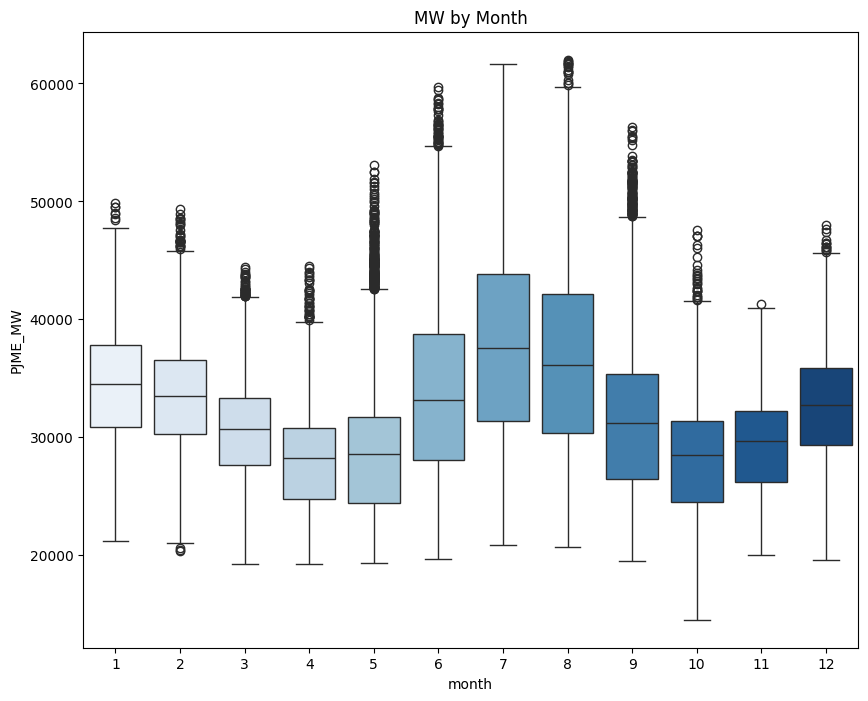

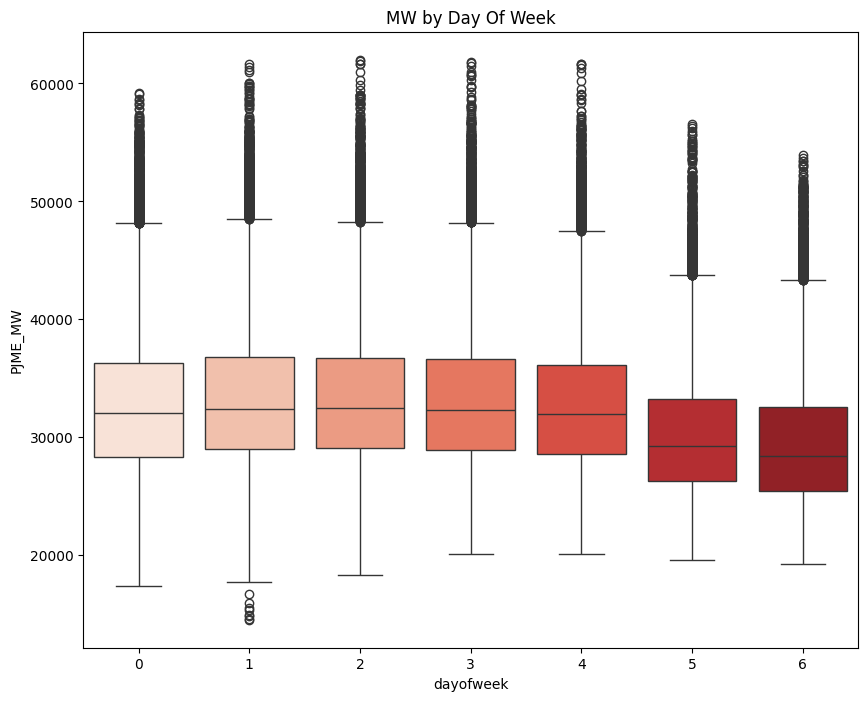

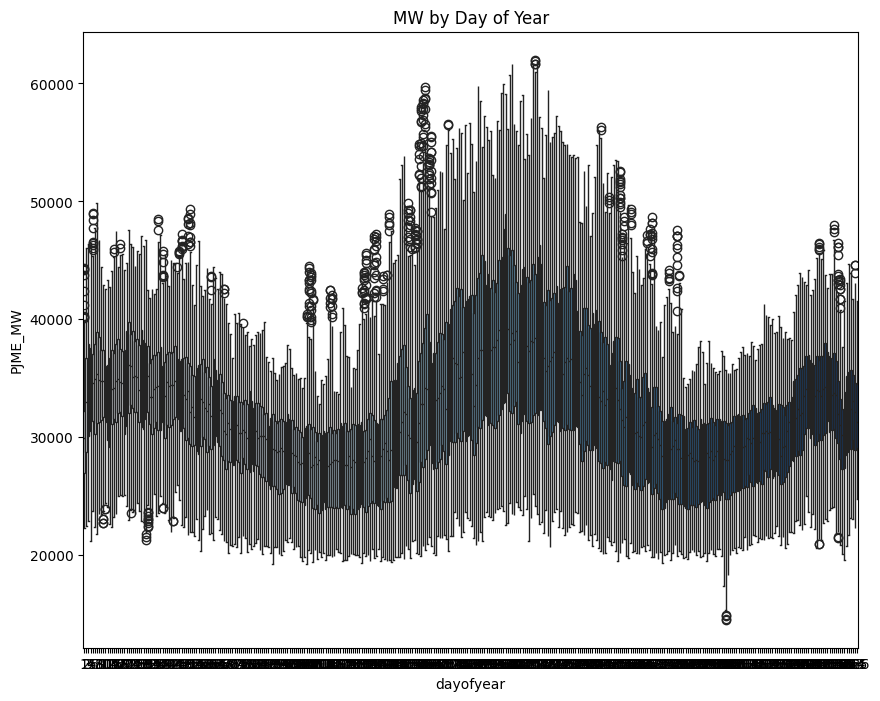

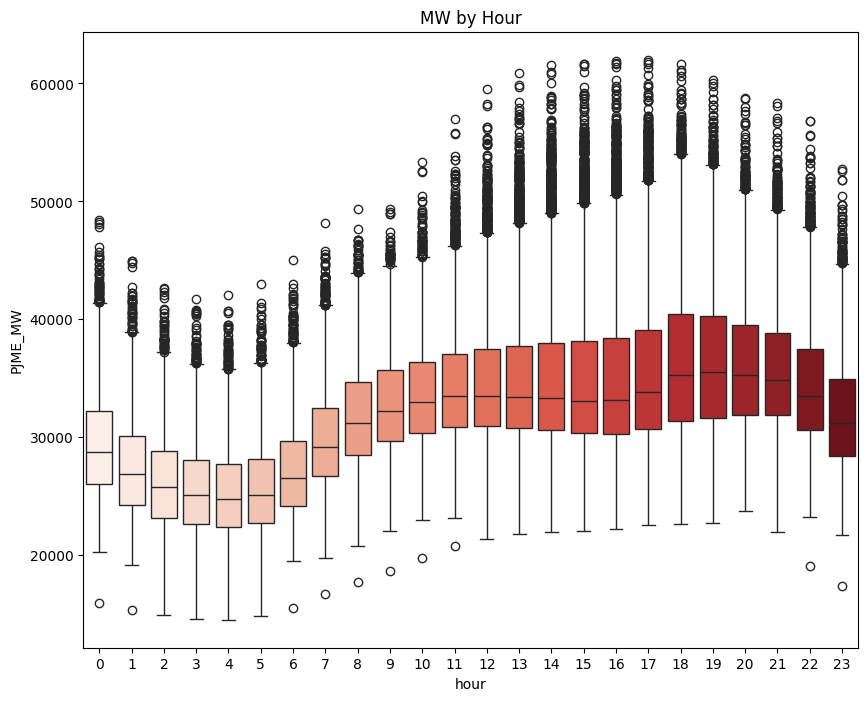

In [8]:
fig, ax= plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues' )
ax.set_title('MW by Month')

fig, ax= plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='dayofweek', y='PJME_MW', palette='Reds')
ax.set_title('MW by Day Of Week')

fig, ax= plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='dayofyear', y='PJME_MW', palette='Blues')
ax.set_title('MW by Day of Year')

fig, ax= plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW',palette='Reds')
ax.set_title('MW by Hour')

* Energy consumption peaks between 7 AM and 7 PM, indicating high demand during daytime hours, likely due to increased industrial and commercial activities.
* Energy consumption is lowest between 12 AM and 3 AM, reflecting reduced demand during late night and early morning hours when most people are asleep.
* Weekdays show higher energy consumption compared to weekends, suggesting a correlation between energy usage and working days, where businesses and industries operate at full capacity during weekdays.
* Months such as January, June, July, August, and December exhibit higher energy consumption, possibly due to seasonal factors such as extreme weather conditions (e.g., hot summer months or cold winter months) or increased commercial activities (e.g., holiday season in December).

# **Check of Stationarity Using Hypothesis testing**

Stationarity is important when forcasting a time series, it simplifies the complexities within time series data, making it easier to model and forecast than a non-stationary time series.
he Augmented Dickey-Fuller Test (ADF) is a statistical method used to detect the stationarity of a time series. The assumptions underlying the ADF test are as follows:

Null Hypothesis (H0):

The null hypothesis states that the time series is non-stationary and contains a unit root.
Failure to reject the null hypothesis implies that the time series is non-stationary and exhibits a unit root.

Alternative Hypothesis (H1):

The alternative hypothesis suggests that the time series is stationary and lacks a unit root.
Rejection of the null hypothesis in favor of the alternative hypothesis indicates that the time series is stationary and does not possess a unit root.

In [9]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['PJME_MW'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -18.828912729084177
p-value: 2.0221245081527322e-30


The time series does not include a unit root, according our  𝐻1
 , and the p-value from the ADF test is less than 0.05, which means we should reject the  𝐻0
  i.e., the time series is stationary.

In [10]:
#creating a copy of Test/train set for XGBoost modelling
train1 = create_features(train)
test1 = create_features(test)

In [11]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113926 entries, 2002-12-31 01:00:00 to 2014-01-02 00:00:00
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   PJME_MW     113926 non-null  float64
 1   hour        113926 non-null  int64  
 2   dayofweek   113926 non-null  int64  
 3   quarter     113926 non-null  int64  
 4   month       113926 non-null  int64  
 5   year        113926 non-null  int64  
 6   dayofyear   113926 non-null  int64  
 7   dayofmonth  113926 non-null  int64  
 8   weekofyear  113926 non-null  UInt32 
dtypes: UInt32(1), float64(1), int64(7)
memory usage: 8.4 MB


In [12]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')

In [13]:
FEATURES=[ 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear']
TARGET=  ['PJME_MW']

In [14]:
#Select inputs and outputs from training and test data:
X_train= train1[FEATURES]
Y_train=train1[TARGET]
X_test= test1[FEATURES]
Y_test=test1[TARGET]

In [15]:
#Creating XGBoost model
reg=xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train,Y_train,
eval_set=[(X_train,Y_train),(X_test,Y_test)],
verbose=True)


[0]	validation_0-rmse:6407.32558	validation_1-rmse:6479.90312
[1]	validation_0-rmse:6362.95260	validation_1-rmse:6438.65470
[2]	validation_0-rmse:6319.24273	validation_1-rmse:6398.29218
[3]	validation_0-rmse:6275.99217	validation_1-rmse:6358.73108
[4]	validation_0-rmse:6233.32679	validation_1-rmse:6319.84676
[5]	validation_0-rmse:6191.25747	validation_1-rmse:6281.82277
[6]	validation_0-rmse:6149.72597	validation_1-rmse:6244.15172
[7]	validation_0-rmse:6108.77159	validation_1-rmse:6207.14046
[8]	validation_0-rmse:6068.28916	validation_1-rmse:6169.82050
[9]	validation_0-rmse:6028.36020	validation_1-rmse:6133.84120
[10]	validation_0-rmse:5988.99958	validation_1-rmse:6098.29696
[11]	validation_0-rmse:5950.11101	validation_1-rmse:6063.27689
[12]	validation_0-rmse:5911.36581	validation_1-rmse:6028.44272
[13]	validation_0-rmse:5873.53185	validation_1-rmse:5994.69038
[14]	validation_0-rmse:5835.83304	validation_1-rmse:5960.88178
[15]	validation_0-rmse:5798.50197	validation_1-rmse:5927.88947
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [16]:
#Grading features by importance
fi= pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_,columns=['importance'])

<Axes: title={'center': 'Feature Importance'}>

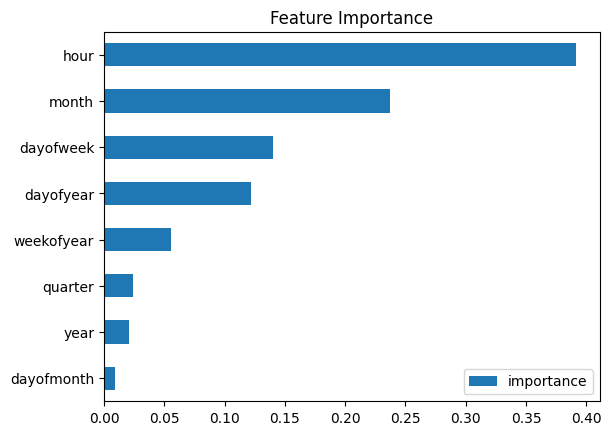

In [17]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

# **FORECAST ON TEST SET**

In [18]:
test1['predictionbyXGB']=reg.predict(X_test)

In [19]:
df= df.merge(test1['predictionbyXGB'], how='left' , left_index=True, right_index=True)

Text(0.5, 1.0, 'Raw Data and predictionsbyXGB')

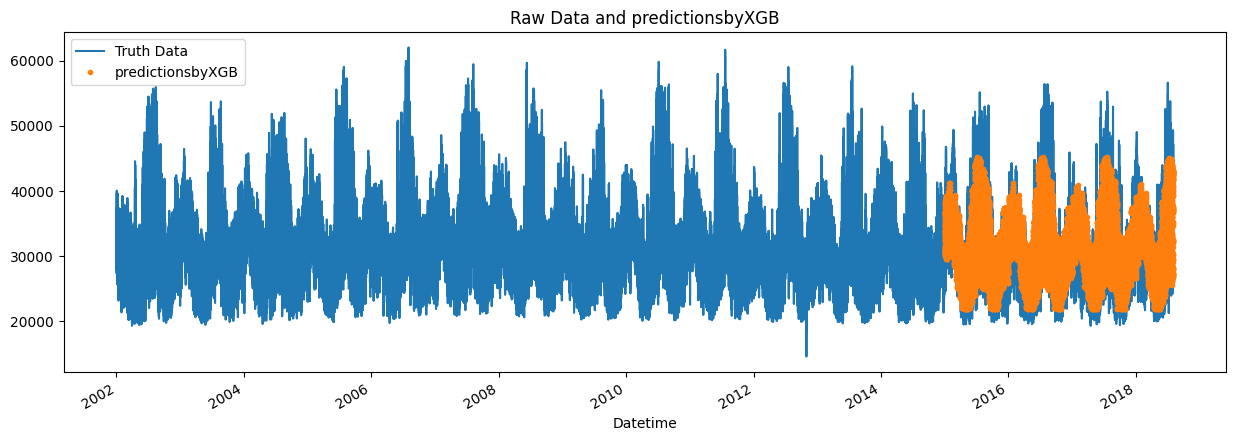

In [20]:
ax=df[['PJME_MW']].plot(figsize=(15,5))
df['predictionbyXGB'].plot(ax=ax , style='.')
plt.legend(['Truth Data', 'predictionsbyXGB'])
ax.set_title('Raw Data and predictionsbyXGB')

Text(0.5, 1.0, 'Actual  and predictionsbyXGB')

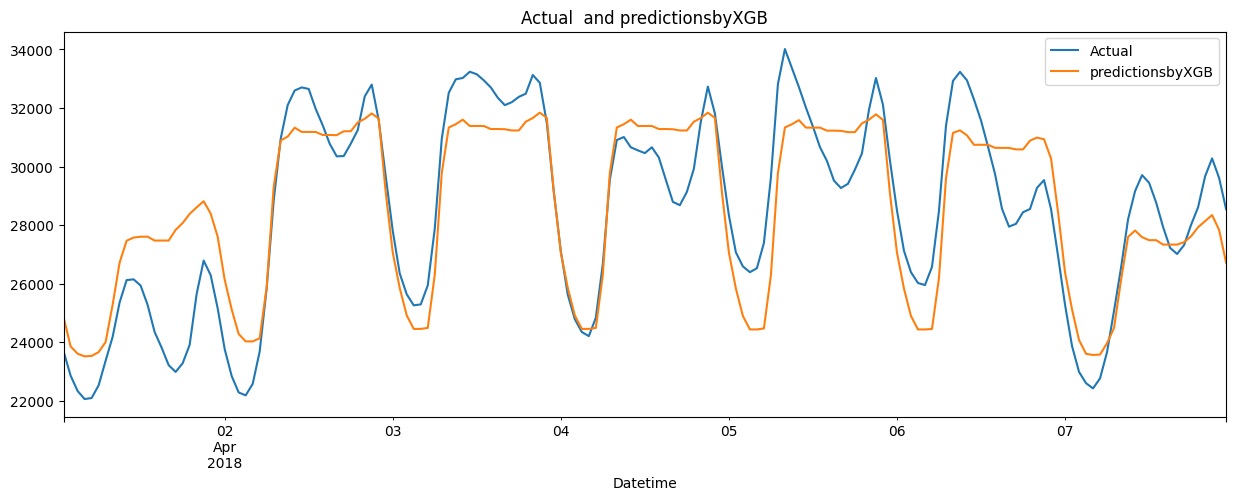

In [21]:
ax=df.loc[(df.index >'04-01-2018') & (df.index < '04-08-2018')]['PJME_MW']\
.plot(figsize=(15,5),
        title='Week Of Date')
df.loc[(df.index >'04-01-2018') & (df.index < '04-08-2018')]['predictionbyXGB']\
.plot()
plt.legend(['Actual', 'predictionsbyXGB'])
ax.set_title('Actual  and predictionsbyXGB')


Modeling isn't perfect, lots of improvement can be made eg. more tuning of parameters or creation of more feature(eg. holidays).

# Forecasting Using the Support Vector Regression (SVR) Model

In [22]:
#Creating copy of train/test for the SVR model
train2=train.copy()
test2=test.copy()

In [23]:
#scaling train set
scaler = MinMaxScaler()
train2['PJME_MW'] = scaler.fit_transform(train2)
train2.head(5)

,PJME_MW
Datetime,
2002-12-31 01:00:00,0.251849
2002-12-31 02:00:00,0.223386
2002-12-31 03:00:00,0.211314
2002-12-31 04:00:00,0.207500
2002-12-31 05:00:00,0.217339


In [24]:
#scaling test set
test2['PJME_MW'] = scaler.transform(test2)
test2.head(5)

,PJME_MW
Datetime,
2015-01-01 00:00:00,0.384662
2015-12-31 01:00:00,0.205646
2015-12-31 02:00:00,0.181439
2015-12-31 03:00:00,0.167913
2015-12-31 04:00:00,0.164037


In [25]:
#Converting to numpy
train_data = train2.values
test_data = test2.values

In [26]:
test_data.shape

(31440, 1)

In [27]:
# Selecting the timesteps

timesteps=5

Converting training data from 1d-tensor (i.e. vector) to 2d-tensor (i.e. matrix) using nested list comprehension:

In [28]:
# Converting train data to 2D tensor
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(113922, 5)

In [29]:
# Converting test data to 2D tensor

test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(31436, 5)

In [30]:
#Select inputs and outputs from training and test data:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(113922, 4) (113922, 1)
(31436, 4) (31436, 1)


The SVR model is implemented as follows:

Model Definition:

The SVR model is instantiated using the SVR() function, with specified hyperparameters such as kernel, gamma, C, and epsilon.
Model Training:

The fit() function is applied to train the model on the provided training dataset.
Prediction:

Predictions are made using the predict() method based on the trained SVR model.
For our specific SVR model implementation, we adjust the hyperparameters gamma, C, and epsilon to 0.5, 10, and 0.05, respectively, while using the RBF kernel.

In [31]:
# Create model using RBF kernel

model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

In [32]:
# Fit model on training data

model.fit(x_train, y_train[:,0])

SVR(C=10, epsilon=0.05, gamma=0.5)

In [33]:
# Making predictions fir train set and test set

y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(113922, 1) (31436, 1)


In [34]:
y_train_pred


array([[0.21847146],
       [0.23847698],
       [0.2764067 ],
       ...,
       [0.42899754],
       [0.3897743 ],
       [0.3395382 ]])

In [35]:
y_train

array([[0.21733909],
       [0.24603392],
       [0.29828295],
       ...,
       [0.41500053],
       [0.37229538],
       [0.32897925]])

In [36]:
y_train_pred.shape

(113922, 1)

Reverse our scaling of the Original and prediction values for evaluation.

In [37]:
#  Reverse Scaling the predictions

y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))


113922 31436


In [38]:
# Scaling the original values

y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

113922 31436


In [39]:
y_train

array([[24860.],
       [26222.],
       [28702.],
       ...,
       [34242.],
       [32215.],
       [30159.]])

In [40]:
y_train_pred

array([[24913.74801238],
       [25863.30979251],
       [27663.64412703],
       ...,
       [34906.36801997],
       [33044.6371705 ],
       [30660.18074938]])

In [41]:
train_timestamps = df[(df.index<'01-01-2015')].index[timesteps-1:]
test_timestamps = df[(df.index>='01-01-2015')].index[timesteps+5:]

print(len(train_timestamps), len(test_timestamps))

113922 31436


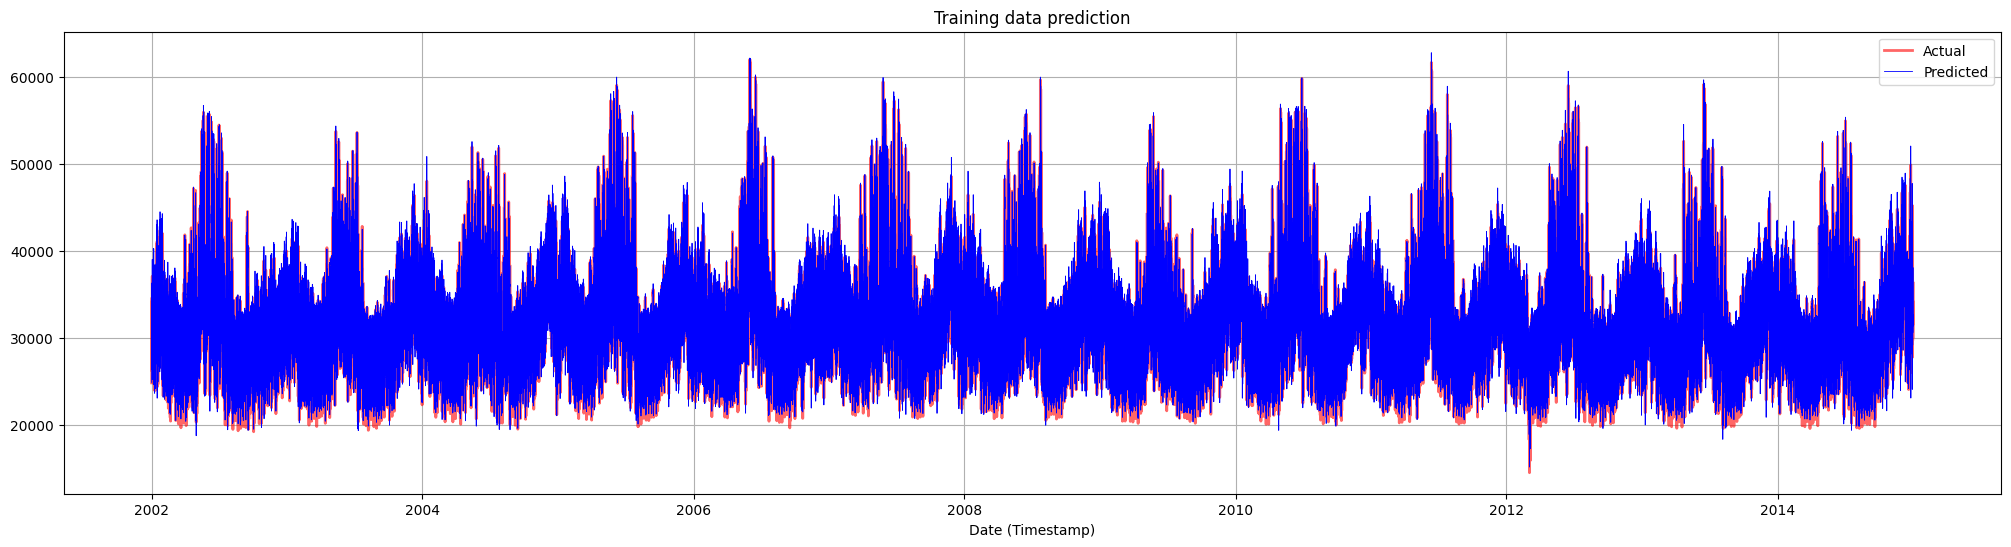

In [42]:
#Visualizing  Actual train set values against predicted train setvalues
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.6)
plt.legend(['Actual','Predicted'])
plt.xlabel('Date (Timestamp)')
plt.title("Training data prediction")
plt.grid()
plt.show()

# **Forecast Performance Measures for Training of SVR Model**

In [43]:
# Report Accuracy metrics for training
def forecast_accuracy(forecast, actual):
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100 # MAPE
  me = np.mean(forecast - actual) # ME
  mae = np.mean(np.abs(forecast - actual)) # MAE
  mpe = np.mean((forecast - actual)/actual) # MPE
  rmse = np.mean((forecast - actual)**2)**.5 # RMSE
  u_statistics = (np.mean((forecast - actual)**2)**.5)/((np.mean((forecast)**2)**.5)*(np.mean((actual)**2)**.5)) # Theils U Statistics
  return({'MAPE':mape, 'ME':me, 'MAE': mae, 'MPE': mpe, 'RMSE':rmse,'Theils U Statistics':u_statistics})

In [44]:
forecast_accuracy(y_train_pred, y_train)

{'MAPE': 2.5317898267011354,
 'ME': 170.02653559777457,
 'MAE': 779.407110435795,
 'MPE': 0.006793905549953239,
 'RMSE': 1070.3405429964798,
 'Theils U Statistics': 9.827770547119212e-07}

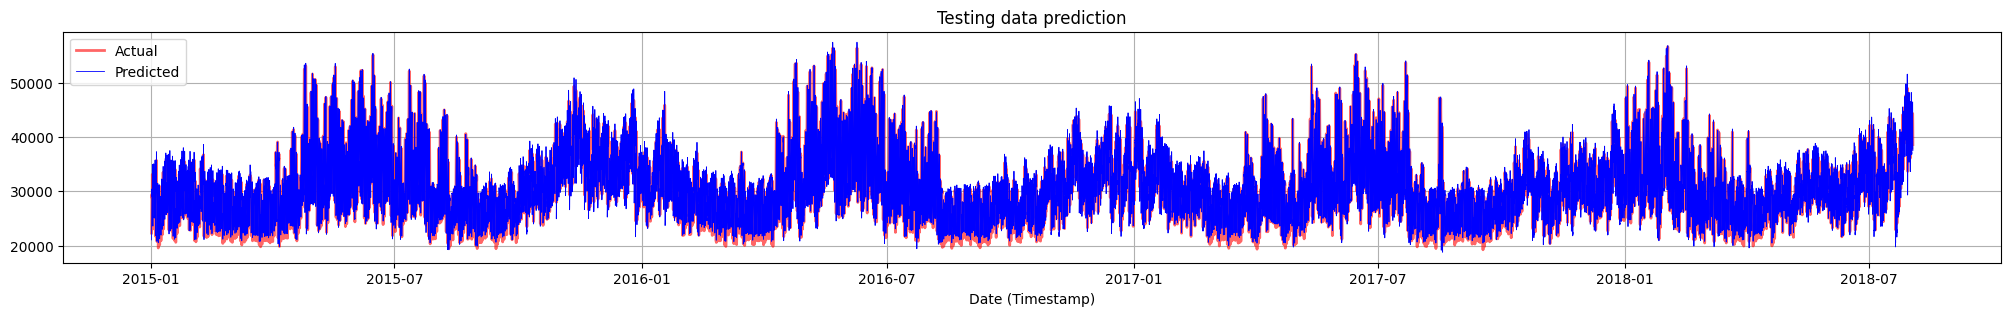

In [45]:
#Visualizing  Actual test set values against predicted test setvalues
plt.figure(figsize=(25,3))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.6)
plt.legend(['Actual','Predicted'])
plt.xlabel('Date (Timestamp)')
plt.title("Testing data prediction")
plt.grid()
plt.show()

SVR seem to be a better model compared to the XGBoost model when it come to the test set values. Lets take a look at the forecasting performancace of both models.

# **Forecast Performance Measures for Testing Set of SVR Model**

In [46]:
forecast_accuracy(y_test_pred, y_test)

{'MAPE': 2.665092443858715,
 'ME': 273.3095560431302,
 'MAE': 783.5725805157716,
 'MPE': 0.010921418252274157,
 'RMSE': 1075.803444609108,
 'Theils U Statistics': 1.0442652977544712e-06}

# **Forecast Performance Measures for Testing Set of XGB Model**

In [47]:
forecast_accuracy( test1['predictionbyXGB'],test1['PJME_MW'])

{'MAPE': 9.23207290879024,
 'ME': 528.795116131421,
 'MAE': 2900.920818113371,
 'MPE': 0.030882000481824094,
 'RMSE': 3737.9876197123294,
 'Theils U Statistics': 3.6247942043093777e-06}

* Mean Absolute Percentage Error (MAPE):

SVR Model: MAPE of 2.67%



XGB Model: MAPE of 9.23%
Lower MAPE indicates better accuracy in forecasting.

Therefore, the SVR model performs better in terms of MAPE.
* Mean Error (ME):

SVR Model: ME of 273.31


XGB Model: ME of 528.80
ME measures the average forecast error. A lower ME indicates closer alignment between predicted and actual values.

 Thus, the SVR model has a lower ME, suggesting better accuracy.
* Mean Absolute Error (MAE):

SVR Model: MAE of 783.57

XGB Model: MAE of 2900.92

MAE represents the average magnitude of errors.Lower MAE implies better accuracy. Therefore, the SVR model outperforms the XGB model in terms of MAE.
* Mean Percentage Error (MPE):

SVR Model: MPE of 0.01%

XGB Model: MPE of 0.03%

MPE indicates the average deviation of forecast errors from actual values as a percentage of actual values. Lower MPE suggests better accuracy. Thus, the SVR model has lower MPE, indicating better performance.

* Root Mean Squared Error (RMSE):

SVR Model: RMSE of 1075.80

XGB Model: RMSE of 3737.99

RMSE measures the square root of the variance between predicted and actual values. Lower RMSE signifies better accuracy. Hence, the SVR model has a lower RMSE, indicating superior performance.

* Theil's U Statistics:

SVR Model: Theil's U Statistics of 1.04e-06

XGB Model: Theil's U Statistics of 3.62e-06

Theil's U Statistics measures the ratio of root mean squared error to the square root of the product of the variances of predicted and actual values. Lower Theil's U Statistics indicates better accuracy. Therefore, the SVR model has a lower Theil's U Statistics, suggesting better performance.

# **Summary**
Based on these forecast performance measures, the SVR model demonstrates superior accuracy and performance compared to the XGB model for forecasting energy consumption.